# FLIP (00): Data Science 
**(Module 04: Probability Theory)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use,but NOT allowed to change and distribute this package.

Prepared by and for 
**Student Members** |
2006-2018 [TULIP Lab](http://www.tulip.org.au), Australia

---
## Session 1 Probability theory

In [2]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')
np.random.seed(1234)

np.set_printoptions(formatter={'all':lambda x: '%.3f' % x})

In [3]:
from IPython.display import Image
from numpy.core.umath_tests import matrix_multiply as mm

<ipython-input-3-7fbcfcc144ce>:2: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import matrix_multiply as mm


In [4]:
from scipy.optimize import minimize
from scipy.stats import bernoulli, binom

Outline
----

- Review of Jensen's inequality
- Concavity of log function
- Example of coin tossing with missing informaiton to provide context
- Derivation of EM equations
- Illustration of EM convergence
- Derivation of update equations of coin tossing example
- Code for coin tossing example
- Derivation of update equatiosn for mixture of Gaussians
- Code for mixture of Gaussians
- More examples to show wide applicability of EM and exercises

Jensen's inequality
----

For a convex function $f$, $E[f(x) \geq f(E[x])$. Flip the signe for a concave function. 

A function $f(x)$ is convex if $f''(x) \geq 0$ everywhere in its domain. For example, if $f(x) = \log x$, $f''(x) = -1/x^2$, so the log function is concave for $x \in (0, \infty]$. A visual illustration of Jensen's inequality is shown below.


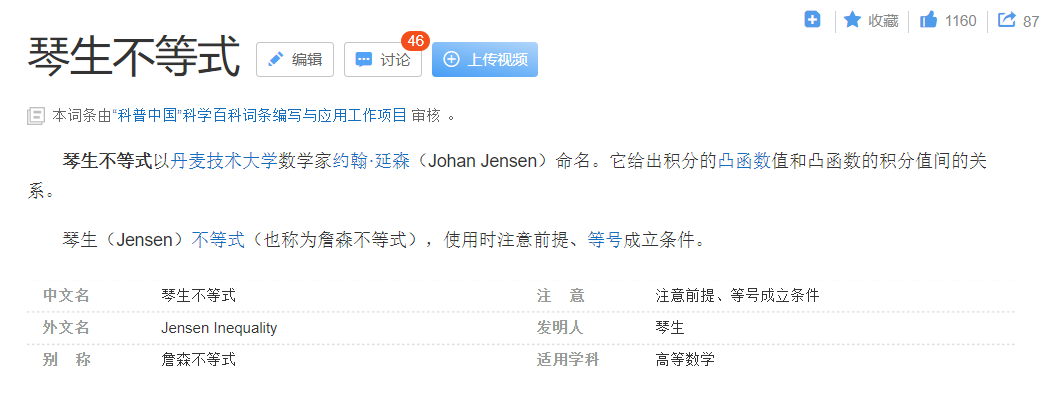

In [5]:
Image(filename='Image/jensen.png')

When is Jensen's inequality an equality? From the diagram, we can see that this only happens if the function $f(x)$ is a constant! We will make use of this fact later on in the lecture.

Maximum likelihood with complete information
----

Consider an experiment with coin $A$ that has a probability $\theta_A$ of heads, and a coin $B$ that has a probability $\theta_B$ of tails. We draw $m$ samples as follows - for each sample, pick one of the coins, flip it 10 times, and record the number of heads and tails. If we recorded which coin we used for each sample, we have *complete* information and can estimate $\theta_A$ and $\theta_B$ in closed form. To be very explicit, suppose we drew 5 samples with the $m$ values represented as a vector $x$, and the sequence of coins chosen was $A, A, B, A, B$. Then the complete log likelihood is 

$$
\log p(x_1; \theta_A) + \log p(x_2; \theta_A) +\ log p(x_3; \theta_B) + \log p(x_4; \theta_A) +\log p(x_5; \theta_B)
$$

where $p(x_i; \theta)$ is the binomial distribtion PMF with $n=m$ and $p=\theta$. We will use $z_i$ to indicate the label of the $i^\text{th}$ coin, that is - whether we used coin $A$ or $B$ to gnerate the $i^\text{th}$ sample.

### Solving for complete likelihood using minimization

In [6]:
def neg_loglik(thetas, n, xs, zs):
    return -np.sum([binom(n, thetas[z]).logpmf(x) for (x, z) in zip(xs, zs)])

In [7]:
m = 10
theta_A = 0.8
theta_B = 0.3
theta_0 = [theta_A, theta_B]

coin_A = bernoulli(theta_A)
coin_B = bernoulli(theta_B)

xs = map(sum, [coin_A.rvs(m), coin_A.rvs(m), coin_B.rvs(m), coin_A.rvs(m), coin_B.rvs(m)])
zs = [0, 0, 1, 0, 1]

In [8]:
bnds = [(0,1), (0,1)]
minimize(neg_loglik, [0.5, 0.5], args=(m, xs, zs), bounds=bnds, method='tnc', options={'maxiter': 100})

     fun: -0.0
     jac: array([0.000, 0.000])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 9
     nit: 1
  status: 2
 success: True
       x: array([0.500, 0.500])

Incomplete information
----

However, if we did not record the coin we used, we have *missing* data and the problem is harder to solve. One way to approach the problem is to ask - can we assign weights $w_i$ to each sample according to how likely it is to be generated from coin $A$ or coin $B$? Intuitively, it seems that the weights should be the posterior distribution of $z_i$, that is
$$
w_i = p(z_i | x_i; \theta)
$$
If we know $z_i$, then we can estiamte $\theta$ since we have the complete likelihood as above. So the basic idea behind Expectation Maximization (EM) is simply to start with a guess for $\theta$, then calculate $z$, then update $\theta$ using this new value for $z$, and repeat till convergence. The derivation below shows why the EM algorithm using this "alternating" updates actually works.

A verbal outline of the derivtion - first consider the log likelihood function as a curve (surface) where the base is $\theta$. Find another function $Q$ of $\theta$ that is a lower bound of the log-likelihood but touches the log likelihodd function at some $\theta$ (E-step). Next find the value of $\theta$ that maximizes this function (M-step). Now find yet antoher function of $\theta$ that is a lower bound of the log-likelihood but touches the log likelihodd function at this new $\theta$. Now repeat until convergence - at this point, the maxima of the lower bound and likelihood functions are the same and we have found the maximum log likelihood. See illustratoin below. 

The only remaining step is how to find the functions that are lower bounds of the log likelihood. This will require a little math using Jensen's inequality, and is shown in the next section.

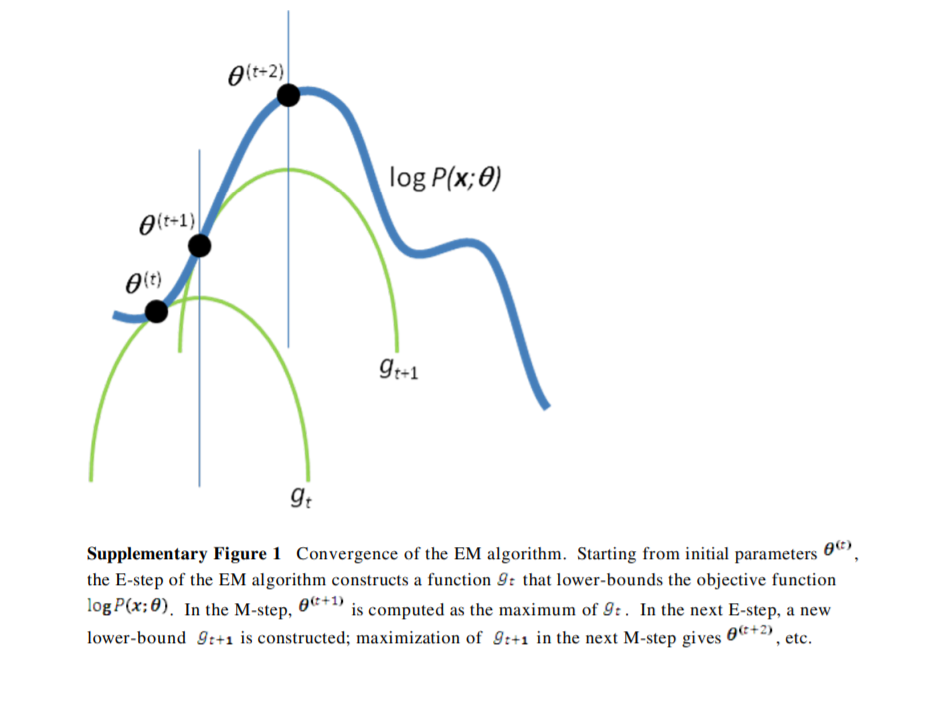

In [9]:
# Image from http://www.nature.com/nbt/journal/v26/n8/extref/nbt1406-S1.pdf
Image(filename='Image/em.png', width=800)

### Derivation

In the E-step, we identify a function which is a lower bound for the log-likelikelihood

\begin{align}
ll &= \sum_i{\log p(x_i; \theta)} && \text{definition of log likelihood} \\
&= \sum_i \log \sum_{z_i}{p(x_i, z_i; \theta)} && \text{augment with latent variables $z$} \\
&= \sum_i \log \sum_{z_i} Q(z_i) \frac{p(x_i, z_i; \theta)}{Q_i(z_i)} && \text{$Q_i$ is a distribution for $z_i$} \\
&= \sum_i \log E_{z_i}[\frac{p(x_i, z_i; \theta)}{Q_i(z_i)}] && \text{taking expectations - hence the E in EM} \\
&\geq \sum E_{z_i}[\log \frac{p(x_i, z_i; \theta)}{Q_i(z_i)}] && \text{Using Jensen's rule for $\log$ which is concave} \\
&\geq \sum_i \sum_{z_i} Q_i(z_i) \log \frac{p(x_i, z_i; \theta)}{Q_i(z_i)} && \text{Q function}
\end{align}

How do we choose the distribution $Q_i$? We want the Q function to touch the log-likelihood, and know that Jensen's inequality is an equality only if the function is constant. So

\begin{align}
\frac{p(x_i, z_i; \theta)}{Q_i(z_i)} =& c \\
\implies Q_i(z_i) &\propto p(x_i, z_i; \theta)\\
\implies Q_i(z_i) &= \frac{p(x_i, z_i; \theta) }{\sum_{z_i}{p(x_i, z_i; \theta)}} &&\text{Since $Q$ is a distribution and sums to 1} \\
\implies Q_i(z_i) &= \frac{p(x_i, z_i; \theta) }{{p(x_i, \theta)}} && \text{marginalizing $z_i$}\\
\implies Q_i(z_i) &= p(z_i | x_i; \theta) && \text{by definition}
\end{align}

So $Q_i$ is just the posterior distribution of $z_i$, and this completes the E-step.

In the M-step, we find the value of $\theta$ that maximizes the Q function, and then we iterate over the E and M steps until convergence. 

So we see that EM is an algorihtm for maximum likelikhood optimization when there is missing inforrmaiton - or when it is useful to add latent augmented variables to simplify maximum likelihood calculatoins.

#### Coin toss example from [What is the expectation maximization algorithm?](http://www.nature.com/nbt/journal/v26/n8/full/nbt1406.html)

For the E-step, we have

\begin{align}
w_j &= Q_i(z_i = j) \\
&= p(z_i = j | x_i; \theta) \\
&= \frac{p(x_i | z_i = j; \theta) p(z_i = j; \phi)}  {\sum_{l=1}^k{p(x_i | z_i = l; \theta) p(z_i = l; \phi)}}  && \text{Baye's rule} \\
&= \frac{\theta_j^h(1-\theta_j)^{n-h} \phi_j}{\sum_{l=1}^k \theta_l^h(1-\theta_l)^{n-h} \phi_l} \\
&= \frac{\theta_j^h(1-\theta_j)^{n-h} }{\sum_{l=1}^k \theta_l^h(1-\theta_l)^{n-h} } && \text{assume $\phi$ is fixed for simplicity}
\end{align}

For the M-step, we need to find the value of $\theta$ that maximises

\begin{align}
& \sum_i \sum_{z_i} Q_i(z_i) \log \frac{p(x_i, z_i; \theta)}{Q_i(z_i)} \\
&= \sum_{i=1}^m \sum_{j=1}^k w_j \log \frac{p(x_i | z_i=j; \theta) \, p(z_i = j; \phi)}{w_j} \\
&= \sum_{i=1}^m \sum_{j=1}^k w_j \log \frac{\theta_j^h(1-\theta_j)^{n-h} \phi_j}{w_j} \\
&= \sum_{i=1}^m \sum_{j=1}^k w_j \left( h \log \theta_j + (n-h) \log (1-\theta_j) + \log \phi_j - \log w_j \right)
\end{align}

We can differentiate and solve for $\theta_s$ where the derivative vanishes

\begin{align}
\sum_{i=1}^m w_s \left( \frac{h}{\theta_s} - \frac{n-h}{1-\theta_s} \right) &= 0  \\
\implies \theta_s &= \frac {\sum_{i=1}^m w_s h}{\sum_{i=1}^m w_s n}
\end{align}


### Implementation in code

In [10]:
def mn_ll(y, theta, axis=None):
    """Log likelihood for multinomial distribution (ignoring constant)."""
    return np.sum(y * np.log(theta), axis=axis)
    # return np.sum(y * np.log(theta))

def ll(y, theta, p):
    """Complete log likelihood for mixture."""
    return np.sum(p * mm_ll(y, theta))

def normalize(xs, axis=1):
    """Return normalized marirx so that sum of row or column (default) entries = 1."""
    if axis==0:
        return xs/xs.sum(0)
    else:
        return xs/xs.sum(1)[:, None]

In [11]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
# theta_A, theta_B = np.array([0.6, 0.4]), np.array([0.5, 0.5])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

tol = 0.01
max_iter = 100

ll_old = 0
for i in range(max_iter):
    exp_A = []
    exp_B = []
    ll_new = 0

    # E-step: calculate probability distributions over possible completions
    for x in xs:

        ll_A = mn_ll(x, thetas[0])
        ll_B = mn_ll(x, thetas[1])
      
        denom = np.exp(ll_A) + np.exp(ll_B)       
        w_A = np.exp(ll_A)/denom
        w_B = np.exp(ll_B)/denom

        exp_A.append(np.dot(w_A, x))
        exp_B.append(np.dot(w_B, x))
        
        # update complete log likelihood
        ll_new += w_A * ll_A + w_B * ll_B
    
    # M-step: update values for parameters given current distribution
    thetas[0] = np.sum(exp_A, 0)/np.sum(exp_A)
    thetas[1] = np.sum(exp_B, 0)/np.sum(exp_B)
    # print distribution of z for each x and current parameter estimate
    print ("Iteration: %d" % (i+1))
    print ("theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new))

    if np.abs(ll_new - ll_old) < tol:
        break
    ll_old = ll_new

Iteration: 1
theta_A = 0.71, theta_B = 0.58, ll = -32.69
Iteration: 2
theta_A = 0.75, theta_B = 0.57, ll = -31.26
Iteration: 3
theta_A = 0.77, theta_B = 0.55, ll = -30.76
Iteration: 4
theta_A = 0.78, theta_B = 0.53, ll = -30.33
Iteration: 5
theta_A = 0.79, theta_B = 0.53, ll = -30.07
Iteration: 6
theta_A = 0.79, theta_B = 0.52, ll = -29.95
Iteration: 7
theta_A = 0.80, theta_B = 0.52, ll = -29.90
Iteration: 8
theta_A = 0.80, theta_B = 0.52, ll = -29.88
Iteration: 9
theta_A = 0.80, theta_B = 0.52, ll = -29.87


### After some cleaning up.

xs = observed data (sampled from multinomial distribution)
wts = conditional distribution of missing data given observed data 
thetas = parameters to estimate

In [12]:
from scipy.stats import binom

In [13]:
binom(n=10, p=0.3).logpmf([4, 3, 7, 9, 1])

array([-1.609, -1.321, -4.710, -8.890, -2.111])

In [14]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])


In [15]:
xs[0].sum()

10

In [26]:
from scipy.stats import binom
from numpy.core.umath_tests import inner1d
    
def _calc_weights(thetas, xs, n):
    s = np.array([binom(n=n, p=theta[0]).logpmf(xs[:, 0]) 
                        for i, theta in enumerate(thetas)])
    es = np.exp(s)
    wts = es/es.sum(1)[:, None]
    ll = inner1d(wts, s).sum()
    return wts, ll    
    
def calc_weights(thetas, xs, n):
    s = np.array([binom(n=n, p=theta).logpmf(xs) 
                        for i, theta in enumerate(thetas)])
    es = np.exp(s)
    wts = es/es.sum(1)[:, None]
    ll = inner1d(wts, s).sum()
    return wts, ll
    
def _calc_thetas(ws, xs):
    thetas = np.dot(ws, xs)
    # print "ws", ws
    # print "xs", xs
    # print "thetas", thetas
    return thetas/thetas.sum(1)[:, None]

def calc_thetas(ws, xs):
    thetas = np.dot(ws, xs)
    # print "ws", ws
    # print "xs", xs
    # print "thetas", thetas
    return thetas/thetas.sum()

def _em(thetas, xs, n):
    for i in range(10):
        ws, ll = _calc_weights(thetas, xs, n)
        thetas = _calc_thetas(ws, xs)
        print (ll, thetas[:,0])

def em(thetas, xs, n):
    for i in range(10):
        ws, ll = calc_weights(thetas, xs, n)
        thetas = calc_thetas(ws, xs)
        print (ll, thetas)

In [27]:
np.random.seed(1234)

n = 1000
p0 = 0.2
p1 = 0.8
xs = np.concatenate([np.random.binomial(n, p0, n//2), np.random.binomial(n, p1, n//2)])
xs_ = np.column_stack((xs, n-xs))
# np.random.shuffle(xs)
print (xs)

[192.000 198.000 191.000 202.000 201.000 219.000 199.000 194.000 173.000
 196.000 198.000 204.000 186.000 195.000 198.000 185.000 210.000 188.000
 200.000 189.000 222.000 202.000 196.000 214.000 213.000 193.000 202.000
 193.000 216.000 187.000 203.000 193.000 202.000 188.000 176.000 192.000
 197.000 206.000 201.000 186.000 238.000 187.000 181.000 208.000 195.000
 217.000 209.000 208.000 197.000 201.000 198.000 213.000 203.000 198.000
 178.000 228.000 195.000 192.000 215.000 227.000 207.000 191.000 210.000
 214.000 191.000 190.000 195.000 212.000 216.000 196.000 210.000 177.000
 189.000 196.000 221.000 225.000 202.000 191.000 203.000 185.000 204.000
 215.000 207.000 195.000 214.000 198.000 209.000 198.000 187.000 207.000
 194.000 221.000 199.000 191.000 197.000 187.000 180.000 193.000 221.000
 206.000 188.000 210.000 208.000 190.000 186.000 200.000 215.000 202.000
 193.000 197.000 218.000 209.000 221.000 193.000 177.000 203.000 221.000
 187.000 203.000 216.000 194.000 189.000 199.000 19

In [28]:
p = np.random.random(2)
p = np.array([0.4, 0.6])
thetas = p
thetas_ = np.column_stack([p, 1-p])

In [29]:
em(thetas, xs, n)

-123.78369629416378 [0.238 0.762]
-9.67971115229726 [0.218 0.782]
-7.962740094743847 [0.209 0.791]
-7.571032287954777 [0.204 0.796]
-7.461484072493622 [0.202 0.798]
-7.429715020222157 [0.201 0.799]
-7.420070486772534 [0.200 0.800]
-7.416896144222061 [0.200 0.800]
-7.4157351010302826 [0.200 0.800]
-7.4152626467709375 [0.199 0.801]


In [30]:
#There may be an error that is not resolved:
#ValueError: operands could not be broadcast together with shapes (2,) (1000,) 

thetas = [(0.4,0.6), (0.6, 0.4)]
em(thetas, xs, n)

ValueError: operands could not be broadcast together with shapes (2,) (1000,) 

In [31]:
thetas = np.array([[0.5, 0.5], [0.5, 0.5]])

In [32]:
em(thetas, xs, n)

ValueError: operands could not be broadcast together with shapes (2,) (1000,) 

In [33]:
thetas

array([[0.500, 0.500],
       [0.500, 0.500]])

In [34]:
calc_weights(thetas, xs, n)

ValueError: operands could not be broadcast together with shapes (2,) (1000,) 

In [36]:

def em(loglik, Qfunc, theta0, max_iter=100, tol=1e-3):
    ll_old = 0
    for i in range(max_iter):
        ll_new = 0

        # E-step
        lls = np.array([mn_ll(x, thetas, axis=1) for x in xs])
        ws = normalize(np.exp(lls))

        # M-step
        thetas = normalize(np.dot(ws.T, xs))

        # update complete log likelihoood 
        ll_new = np.sum(np.dot(w, ll) for (w, ll) in zip(ws, lls))

        # print distribution of z for each x and current parameter estimate
        print ("Iteration: %d" % (i+1))
        print ("theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new))
        print ("Weights\n", \
            pd.DataFrame(normalize(ws), columns=['A', 'B'], index=range(1, 1+len(xs))), "\n")

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

In [38]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
# thetas = normalize(np.random.random((2,2)))
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

tol = 0.01
max_iter = 100

ll_old = 0
for i in range(max_iter):
    exp_A = []
    exp_B = []
    ll_new = 0

    # E-step
    lls = np.array([mn_ll(x, thetas, axis=1) for x in xs])
    ws = normalize(np.exp(lls))
       
    print (">>", ws.shape)
    print (">>", xs.shape)
        
    # M-step
    thetas = normalize(np.dot(ws.T, xs))
    
    # update complete log likelihoood 
    ll_new = np.sum(np.dot(w, ll) for (w, ll) in zip(ws, lls))
    
    # print distribution of z for each x and current parameter estimate
    print ("Iteration: %d" % (i+1))
    print ("theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new))
    print ("Weights\n", \
        pd.DataFrame(normalize(ws), columns=['A', 'B'], index=range(1, 1+len(xs))), "\n")
 
    if np.abs(ll_new - ll_old) < tol:
        break
    ll_old = ll_new

>> (5, 2)
>> (5, 2)
Iteration: 1
theta_A = 0.71, theta_B = 0.58, ll = -32.69
Weights
           A         B
1  0.449149  0.550851
2  0.804986  0.195014
3  0.733467  0.266533
4  0.352156  0.647844
5  0.647215  0.352785 

>> (5, 2)
>> (5, 2)
Iteration: 2
theta_A = 0.75, theta_B = 0.57, ll = -31.26
Weights
           A         B
1  0.295819  0.704181
2  0.811510  0.188490
3  0.706422  0.293578
4  0.190145  0.809855
5  0.573534  0.426466 

>> (5, 2)
>> (5, 2)
Iteration: 3
theta_A = 0.77, theta_B = 0.55, ll = -30.76
Weights
           A         B
1  0.217592  0.782408
2  0.869849  0.130151
3  0.751154  0.248846
4  0.111591  0.888409
5  0.576869  0.423131 

>> (5, 2)
>> (5, 2)
Iteration: 4
theta_A = 0.78, theta_B = 0.53, ll = -30.33
Weights
           A         B
1  0.161703  0.838297
2  0.912905  0.087095
3  0.794264  0.205736
4  0.066333  0.933667
5  0.587105  0.412895 

>> (5, 2)
>> (5, 2)
Iteration: 5
theta_A = 0.79, theta_B = 0.53, ll = -30.07
Weights
           A         B
1  0.129020 

<ipython-input-38-25d4fd82edc3>:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  ll_new = np.sum(np.dot(w, ll) for (w, ll) in zip(ws, lls))
<ipython-input-38-25d4fd82edc3>:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  ll_new = np.sum(np.dot(w, ll) for (w, ll) in zip(ws, lls))
<ipython-input-38-25d4fd82edc3>:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  ll_new = np.sum(np.dot(w, ll) for (w, ll) in zip(ws, lls))
<ipython-input-38-25d4fd82edc3>:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gene

Gaussian mixture models
----

A mixture of $k$ Gaussians has the following PDF

\begin{align}
p(x) = \sum_{j=1}^k \alpha_j \phi(x; \mu_j, \Sigma_j)
\end{align}

where $\alpha_j$ is the weight of the $j^\text{th}$ Gaussain component and 

\begin{align}
\phi(x; \mu, \Sigma) = \frac{1}{(2 \pi)^{d/2}|\Sigma|^{1/2}} \exp \left( -\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu) \right)
\end{align}

Suppose we observe $y_1, y2, \ldots, y_n$ as a sample from a mixture of Gaussians. The log-likeihood is then

\begin{align}
l(\theta) = \sum_{i=1}^n \log \left( \sum_{j=1}^k \alpha_j \phi(y_i; \mu_j, \Sigma_j) \right)
\end{align}

where $\theta = (\alpha, \mu, \Sigma)$

There is no closed form for maximizing the parameters of this log-likelihood, and it is hard to maximize directly.

Using EM
----

Suppose we augment with the latent variable $z$ that indicates which of the $k$ Gaussians our observation $y$ came from. The derivation of the E and M steps are the same as for the toy example, only with more algebra.

For the E-step, we have

\begin{align}
w_j^i &= Q_i(z^i = j) \\
&= p(z^i = j | y^i; \theta) \\
&= \frac{p(y^i | z^i = j; \mu, \Sigma) p(z^i = j; \alpha)}  {\sum_{l=1}^k{p(y^i | z^i = l; \mu, \Sigma) p(z^i = l; \alpha)}}  && \text{Baye's rule} \\
&= \frac{\phi(y^i; \mu_j, \Sigma_j) \alpha_j}{\sum_{l=1}^k \phi(y^i; \mu_l, \Sigma_l) \alpha_l}
\end{align}

For the M-step, we have to find $\theta = (w, \mu, \Sigma)$ that maximizes $Q$

\begin{align}
\sum_{i=1}^{m}\sum{j=1}^{k} Q(z^i=j) \log \frac{p(x^i | z^i= j; \mu, \Sigma) p(z^i=j; \alpha)}{Q(z^i=j)}
\end{align}

By taking derivatives with respect to $(w, \mu, \Sigma)$ respectively and solving (remember to use Lagrange multipliers for the constraint that $\sum_{j=1}^k w_j = 1$), we get

\begin{align}
\alpha_j &= \frac{1}{m} \sum_{i=1}^{m} w_j^i \\
\mu_j &= \frac{\sum_{i=1}^{m} w_j^i x^i}{\sum_{i=1}^{m} w_j^i} \\
\Sigma_j &= \frac{\sum_{i=1}^{m} w_j^i (x^i - \mu)(x^i - \mu)^T}{\sum_{i1}^{m} w_j^i}
\end{align}

In [39]:
from scipy.stats import multivariate_normal as mvn

def normalize(xs, axis=None):
    """Return normalized marirx so that sum of row or column (default) entries = 1."""
    if axis is None:
        return xs/xs.sum()
    elif axis==0:
        return xs/xs.sum(0)
    else:
        return xs/xs.sum(1)[:, None]

def mix_mvn_pdf(xs, pis, mus, sigmas):
    return np.array([pi*mvn(mu, sigma).pdf(xs) for (pi, mu, sigma) in zip(pis, mus, sigmas)])

In [40]:
def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

    #     # vectorized version
    #     for j in range(len(mus)):
    #         ws[j, :] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs)
    #     ws /= ws.sum(0)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

    #     # vectorization 1
    #     pis = np.zeros(len(mus))
    #     for j in range(len(mus)):
    #         pis[j] = ws[j,:].sum()
    #     pis /= m

    #     # vectorization 2
    #     pis = ws.sum(axis=1)
    #     pis /= m

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()

    #     # vectorization 1
    #     mus = np.zeros((len(mus), p))
    #     for j in range(len(mus)):
    #         for k in range(m):
    #             mus[j] += ws[j, k] * xs[k]
    #     mus /= ws.sum(axis=1)[:, None]

    #     # Vectorization 2
    #     mus = np.zeros((len(mus), p))
    #     for j in range(len(mus)):
    #         mus[j, :] = np.dot(ws[j, :], xs)
    #         mus[j] /= ws[j, :].sum()

    #     # Vectorization 3
    #     mus = np.dot(ws, xs)
    #     mus /= ws.sum(1)[:, None]

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

    #     # Vectorization 1
    #     sigmas = np.zeros((len(mus), p, p))
    #     for j in range(len(mus)):
    #         ys = xs - mus[j, :]
    #         sigmas[j] = (ws[j,:,None,None] * mm(ys[:,:,None], ys[:,None,:])).sum(axis=0)
    #     sigmas /= ws.sum(axis=1)[:,None,None]

        # update complete log likelihoood 
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)

    #     # Vectorization 1
    #     ll_new = 0
    #     for pi, mu, sigma in zip(pis, mus, sigmas):
    #         ll_new += pi*mvn(mu, sigma).pdf(xs)
    #     ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

Vectorized version
----

In [41]:
def em_gmm_vect(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(k):
            ws[j, :] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs)
        ws /= ws.sum(0)

        # M-step
        pis = ws.sum(axis=1)
        pis /= n

        mus = np.dot(ws, xs)
        mus /= ws.sum(1)[:, None]

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            ys = xs - mus[j, :]
            sigmas[j] = (ws[j,:,None,None] * mm(ys[:,:,None], ys[:,None,:])).sum(axis=0)
        sigmas /= ws.sum(axis=1)[:,None,None]

        # update complete log likelihoood 
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi*mvn(mu, sigma).pdf(xs)
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

Vectorization with Einstein summation notation
----

In [42]:
def em_gmm_eins(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j, (pi, mu, sigma) in enumerate(zip(pis, mus, sigmas)):
            ws[j, :] = pi * mvn(mu, sigma).pdf(xs)
        ws /= ws.sum(0)

        # M-step
        pis = np.einsum('kn->k', ws)/n
        mus = np.einsum('kn,np -> kp', ws, xs)/ws.sum(1)[:, None]
        sigmas = np.einsum('kn,knp,knq -> kpq', ws, 
            xs-mus[:,None,:], xs-mus[:,None,:])/ws.sum(axis=1)[:,None,None]

        # update complete log likelihoood 
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi*mvn(mu, sigma).pdf(xs)
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

Comparison of EM routines
----

In [43]:
np.random.seed(123)

# create data set
n = 1000
_mus = np.array([[0,4], [-2,0]])
_sigmas = np.array([[[3, 0], [0, 0.5]], [[1,0],[0,2]]])
_pis = np.array([0.6, 0.4])
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n)) 
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])

# initial guesses for parameters
pis = normalize(np.random.random(2))
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)

In [45]:
%%time
ll1, pis1, mus1, sigmas1 = em_gmm_orig(xs, pis, mus, sigmas)

Wall time: 14.3 s


<ipython-input-46-98c775b17953>:13: UserWarning: The following kwargs were not used by contour: 'N'
  plt.contour(X, Y, z, N=10)


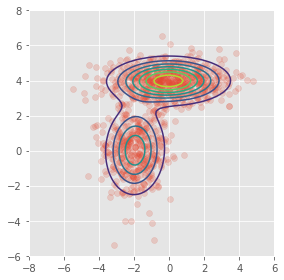

In [46]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis1, mus1, sigmas1):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()

In [47]:
%%time
ll2, pis2, mus2, sigmas2 = em_gmm_vect(xs, pis, mus, sigmas)

Wall time: 16 ms


<ipython-input-48-bc5d49b872ef>:13: UserWarning: The following kwargs were not used by contour: 'N'
  plt.contour(X, Y, z, N=10)


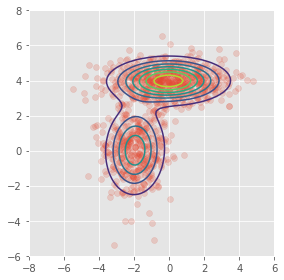

In [48]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis2, mus2, sigmas2):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()

In [49]:
%%time
ll3, pis3, mus3, sigmas3 = em_gmm_eins(xs, pis, mus, sigmas)

Wall time: 18 ms


In [50]:
# %timeit em_gmm_orig(xs, pis, mus, sigmas)
%timeit em_gmm_vect(xs, pis, mus, sigmas)
%timeit em_gmm_eins(xs, pis, mus, sigmas)

13.9 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.9 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<ipython-input-53-869cbd8b833b>:13: UserWarning: The following kwargs were not used by contour: 'N'
  plt.contour(X, Y, z, N=10)


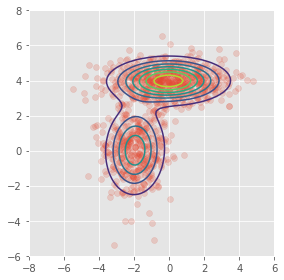

In [53]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis3, mus3, sigmas3):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()